# 使用基于领域知识的特征对神经网络的多个分组模型进行训练

- 导入数据

In [1]:
# 导库
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression

In [2]:
# 一些参数
TEST_SIZE = 0.30
RANDOM_STATE = 42

In [3]:
# 导入数据
data_group0 = pd.read_csv('../../data/groups/data_training_cluster_0of5.csv')
data_group4 = pd.read_csv('../../data/groups/data_training_cluster_4of5.csv')

- 创建X 和 y

In [4]:
X_0 = data_group0.drop(columns=['e_total', 'e_ionic', 'e_electronic'])
y_0 = data_group0['e_total']
X_4 = data_group4.drop(columns=['e_total', 'e_ionic', 'e_electronic'])
y_4 = data_group4['e_total']

- 搭建模型

In [5]:
# 加载数据
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets.to_numpy().reshape(-1, 1)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # 根据索引获取数据和目标，并将它们转换为张量
        x = torch.tensor(self.data[index], dtype=torch.float32)
        y = torch.tensor(self.targets[index], dtype=torch.float32)
        return x, y
    


In [6]:
# 搭建神经网络
import torch.nn as nn
# 导入optim
import torch.optim as optim

class NN_model(nn.Module):
    def __init__(self):
        super(NN_model, self).__init__()
        
        # 使用Sequential定义神经网络的结构
        self.layers = nn.Sequential(
            nn.BatchNorm1d(18),
            nn.Linear(18, 12),
            nn.ReLU(),
            nn.Linear(12, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1)
        )
        
    def forward(self, x):
        # 前向传播
        return self.layers(x)

- 模型训练

In [31]:
def data_load(X, y):
    # 训练集测试集划分
    X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    # 创建自定义数据集实例
    dataset = CustomDataset(X_train, y_train)   # 注意X_train,y_train都为pandas.DataFrame
    # 创建数据加载器
    batch_size = 64
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return data_loader, dataset, X_train, y_train, X_test, y_test

def nn_train(data_loader, dataset, learning_rate, num_epochs):
    device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')

    print(device)

    # 初始化模型、损失函数和优化器
    model = NN_model()
    # 使用均方误差作为损失函数
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.to(device)
    criterion.to(device)
    # 训练模型
    model.train()
    for epoch in range(num_epochs):
        # Forward pass
        epoch_loss = 0
        for i, (features, targets) in enumerate(data_loader):
            features = features.to(device)
            targets = targets.to(device)
            outputs = model(features)
            loss = criterion(outputs, targets)
            epoch_loss += loss.item()
            # Backward and optimize
            optimizer.zero_grad()    # 梯度重置
            loss.backward() # 向后传播计算梯度
            optimizer.step() # 通过梯度更新参数

        if (epoch+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, MSE: {epoch_loss/len(dataset):.4f}')

    return model

# 模型测试
def nn_test(model, X_test, y_test):
    # 测试模型
    model.eval()
    with torch.no_grad():
        X_test = torch.tensor(X_test, dtype=torch.float32)
        y_test = torch.tensor(y_test.to_numpy().reshape(-1, 1), dtype=torch.float32)
        y_pred = model(X_test).numpy()
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        return y_pred, mse, mae

In [32]:
def plot_cross_val_scores(mse, mae, y_hat, y_train):
    '''绘制交叉验证的结果'''
    print(f'MSE: {mse}, MAE: {mae}')

    # 绘制parity plot
    fig, ax = plt.subplots(dpi=300)
    ax.scatter(y_train, y_hat, s=1)
    ax.plot(y_train, y_train, c='k', zorder=-5)
    ax.set_xlabel('Actual $\epsilon_{total}$')
    ax.set_ylabel('Predicted $\epsilon_{total}$')
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    ax.set_xlim(0, 200)
    ax.set_ylim(0, 200)
    plt.show()

In [33]:
def nn_train_test(X, y, learning_rate=0.001, num_epochs=1000):
    # 加载数据
    data_loader, dataset, X_train, y_train, X_test, y_test = data_load(X, y)
    # 训练模型
    model = nn_train(data_loader, dataset, learning_rate, num_epochs)

    y_hat, mse, mae = nn_test(model, X_train, y_train)
    plot_cross_val_scores(mse, mae, y_hat, y_train)
    # 测试模型
    y_pred, mse, mae = nn_test(model, X_test, y_test)
    plot_cross_val_scores(mse, mae, y_pred, y_test)
    return model

cpu
Epoch [50/1000], Loss: 420484.0676, MSE: 177.5693
Epoch [100/1000], Loss: 412589.3234, MSE: 174.2354
Epoch [150/1000], Loss: 403840.7944, MSE: 170.5409
Epoch [200/1000], Loss: 386451.2910, MSE: 163.1973
Epoch [250/1000], Loss: 392255.3569, MSE: 165.6484
Epoch [300/1000], Loss: 374859.2943, MSE: 158.3021
Epoch [350/1000], Loss: 369220.1872, MSE: 155.9207
Epoch [400/1000], Loss: 365195.8454, MSE: 154.2212
Epoch [450/1000], Loss: 358691.3997, MSE: 151.4744
Epoch [500/1000], Loss: 327408.3764, MSE: 138.2637
Epoch [550/1000], Loss: 336621.3403, MSE: 142.1543
Epoch [600/1000], Loss: 349206.6518, MSE: 147.4690
Epoch [650/1000], Loss: 324824.1903, MSE: 137.1724
Epoch [700/1000], Loss: 345136.0007, MSE: 145.7500
Epoch [750/1000], Loss: 342033.2335, MSE: 144.4397
Epoch [800/1000], Loss: 333466.5890, MSE: 140.8220
Epoch [850/1000], Loss: 306881.1170, MSE: 129.5951
Epoch [900/1000], Loss: 311660.9540, MSE: 131.6136
Epoch [950/1000], Loss: 302791.2167, MSE: 127.8679
Epoch [1000/1000], Loss: 351

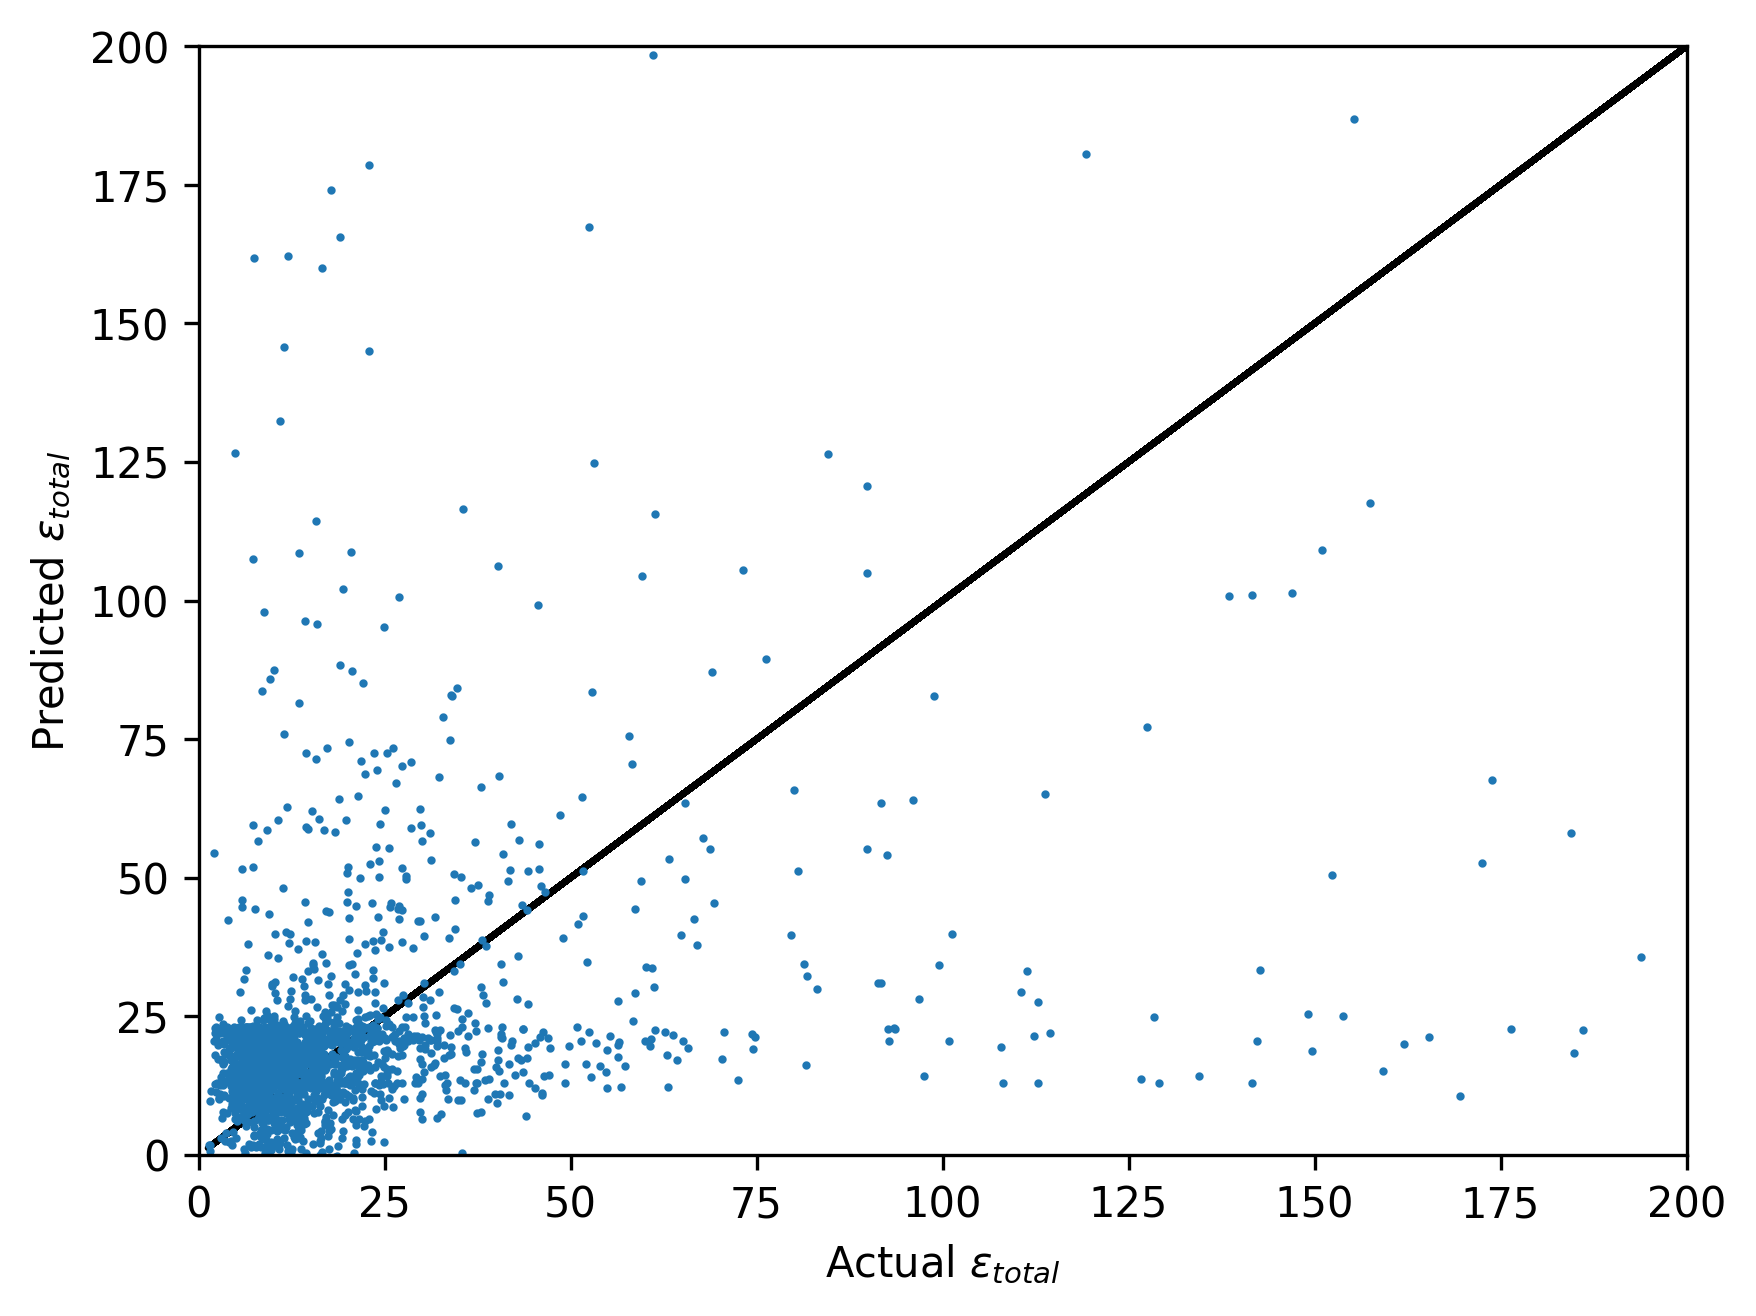

MSE: 11604.8818359375, MAE: 27.163354873657227


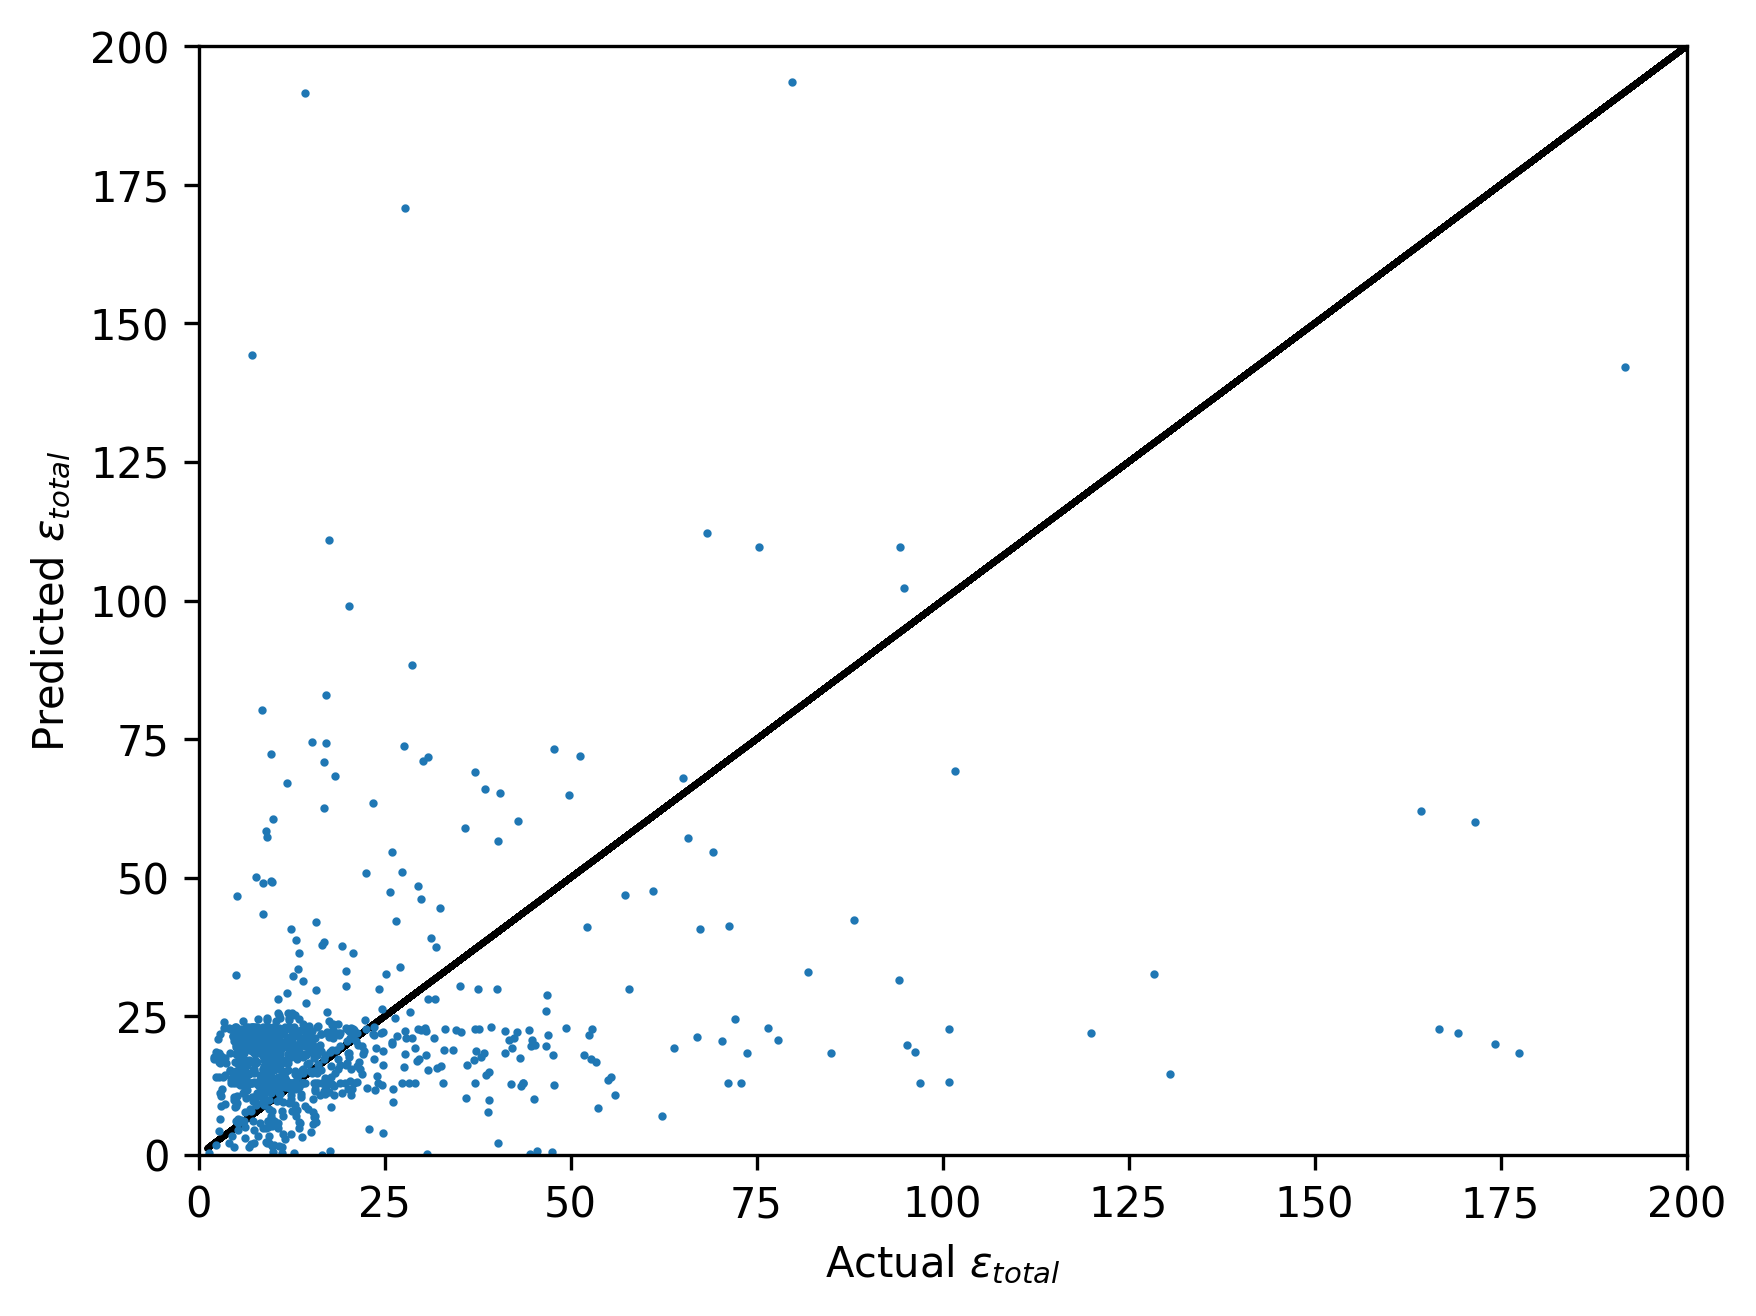

In [35]:
# group0
model_0 = nn_train_test(X_0, y_0, learning_rate=0.0015, num_epochs=1000)

- 这个训练的还算可以

cpu
Epoch [50/1000], Loss: 43127.0342, MSE: 15.8381
Epoch [100/1000], Loss: 42682.4365, MSE: 15.6748
Epoch [150/1000], Loss: 50710.6505, MSE: 18.6231
Epoch [200/1000], Loss: 41772.8062, MSE: 15.3407
Epoch [250/1000], Loss: 38972.6940, MSE: 14.3124
Epoch [300/1000], Loss: 39485.6050, MSE: 14.5008
Epoch [350/1000], Loss: 39250.1148, MSE: 14.4143
Epoch [400/1000], Loss: 38642.6659, MSE: 14.1912
Epoch [450/1000], Loss: 36216.7314, MSE: 13.3003
Epoch [500/1000], Loss: 36167.9913, MSE: 13.2824
Epoch [550/1000], Loss: 37046.3214, MSE: 13.6050
Epoch [600/1000], Loss: 36900.7653, MSE: 13.5515
Epoch [650/1000], Loss: 30946.6034, MSE: 11.3649
Epoch [700/1000], Loss: 30116.9952, MSE: 11.0602
Epoch [750/1000], Loss: 25189.4634, MSE: 9.2506
Epoch [800/1000], Loss: 33421.8044, MSE: 12.2739
Epoch [850/1000], Loss: 30484.6137, MSE: 11.1952
Epoch [900/1000], Loss: 36846.3036, MSE: 13.5315
Epoch [950/1000], Loss: 31915.0145, MSE: 11.7205
Epoch [1000/1000], Loss: 31834.9389, MSE: 11.6911
MSE: 588.27532958

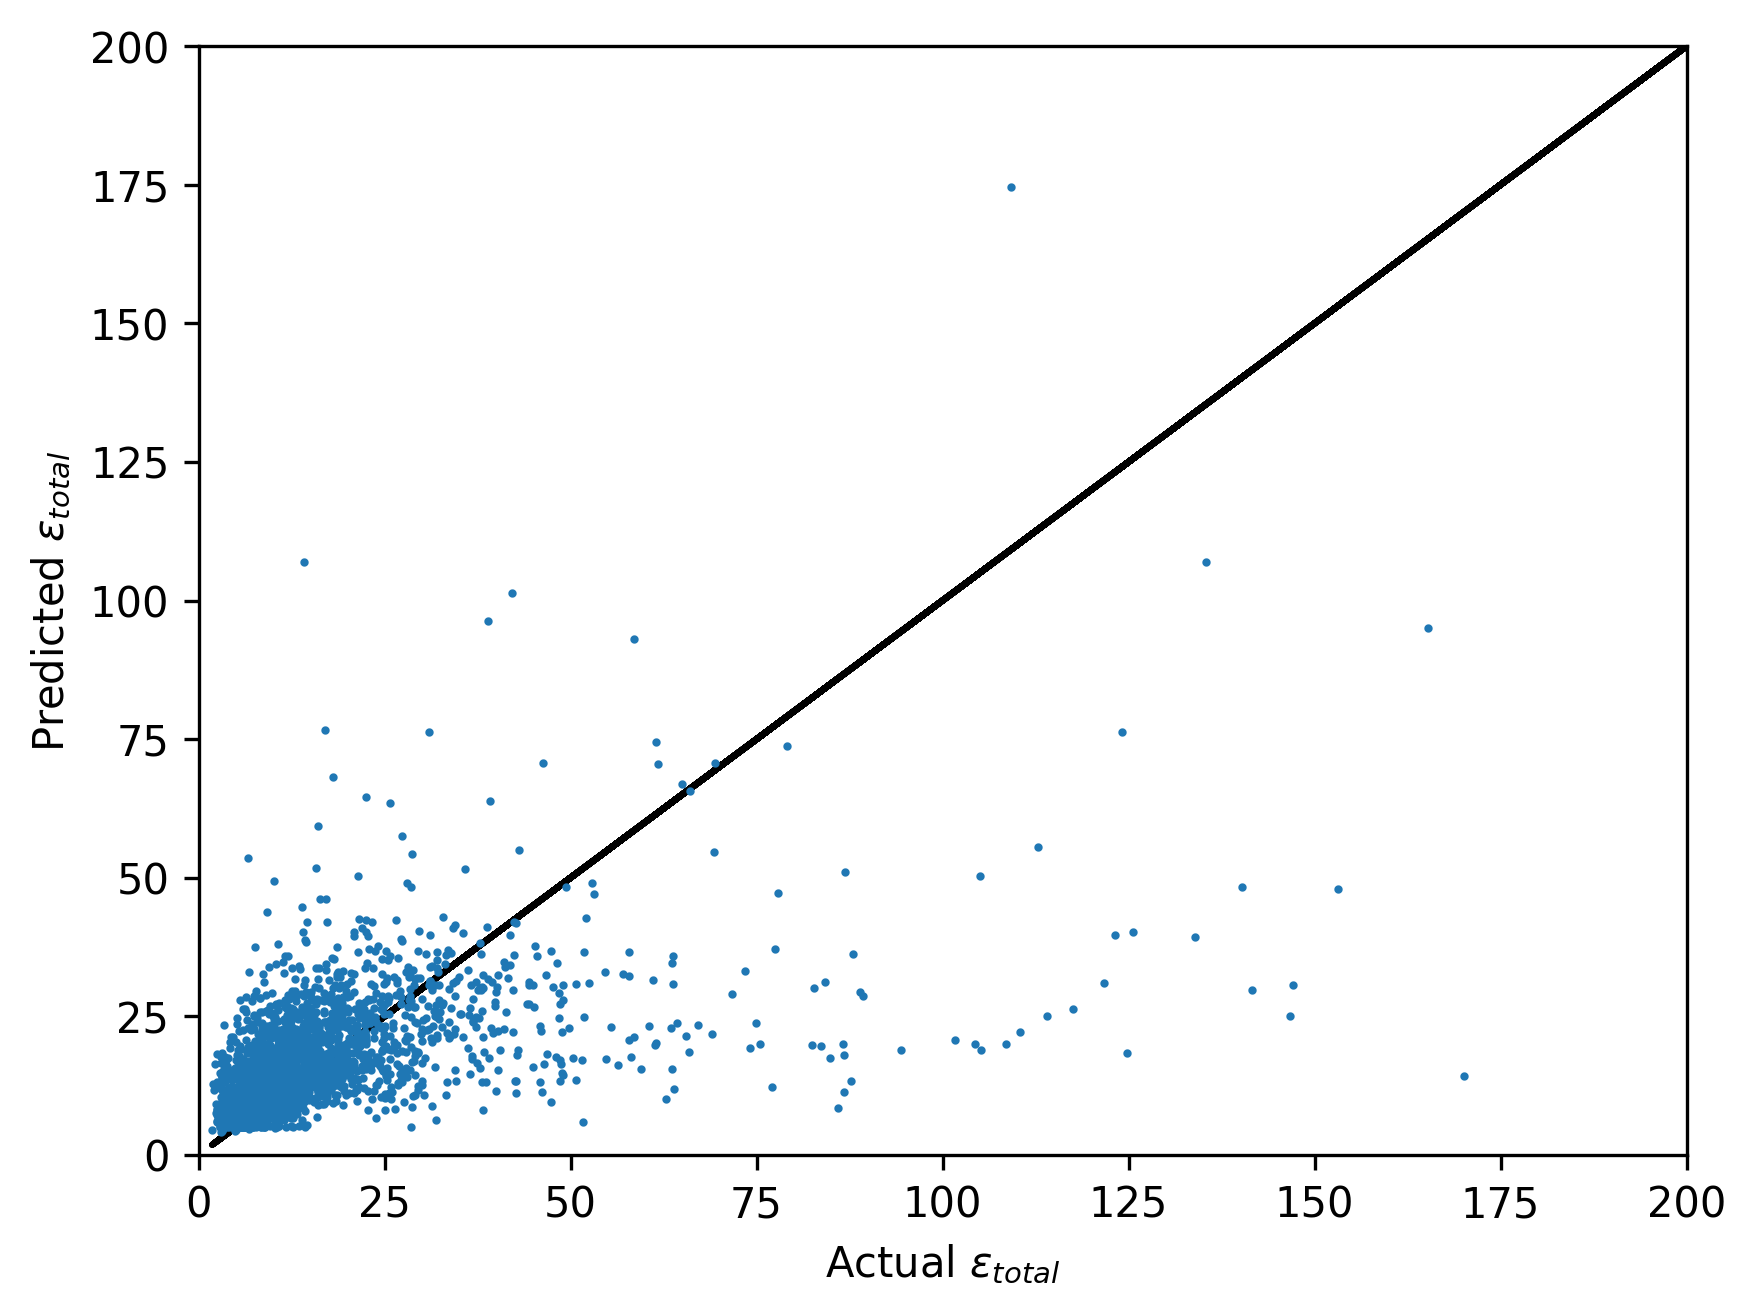

MSE: 1014.4569702148438, MAE: 9.848143577575684


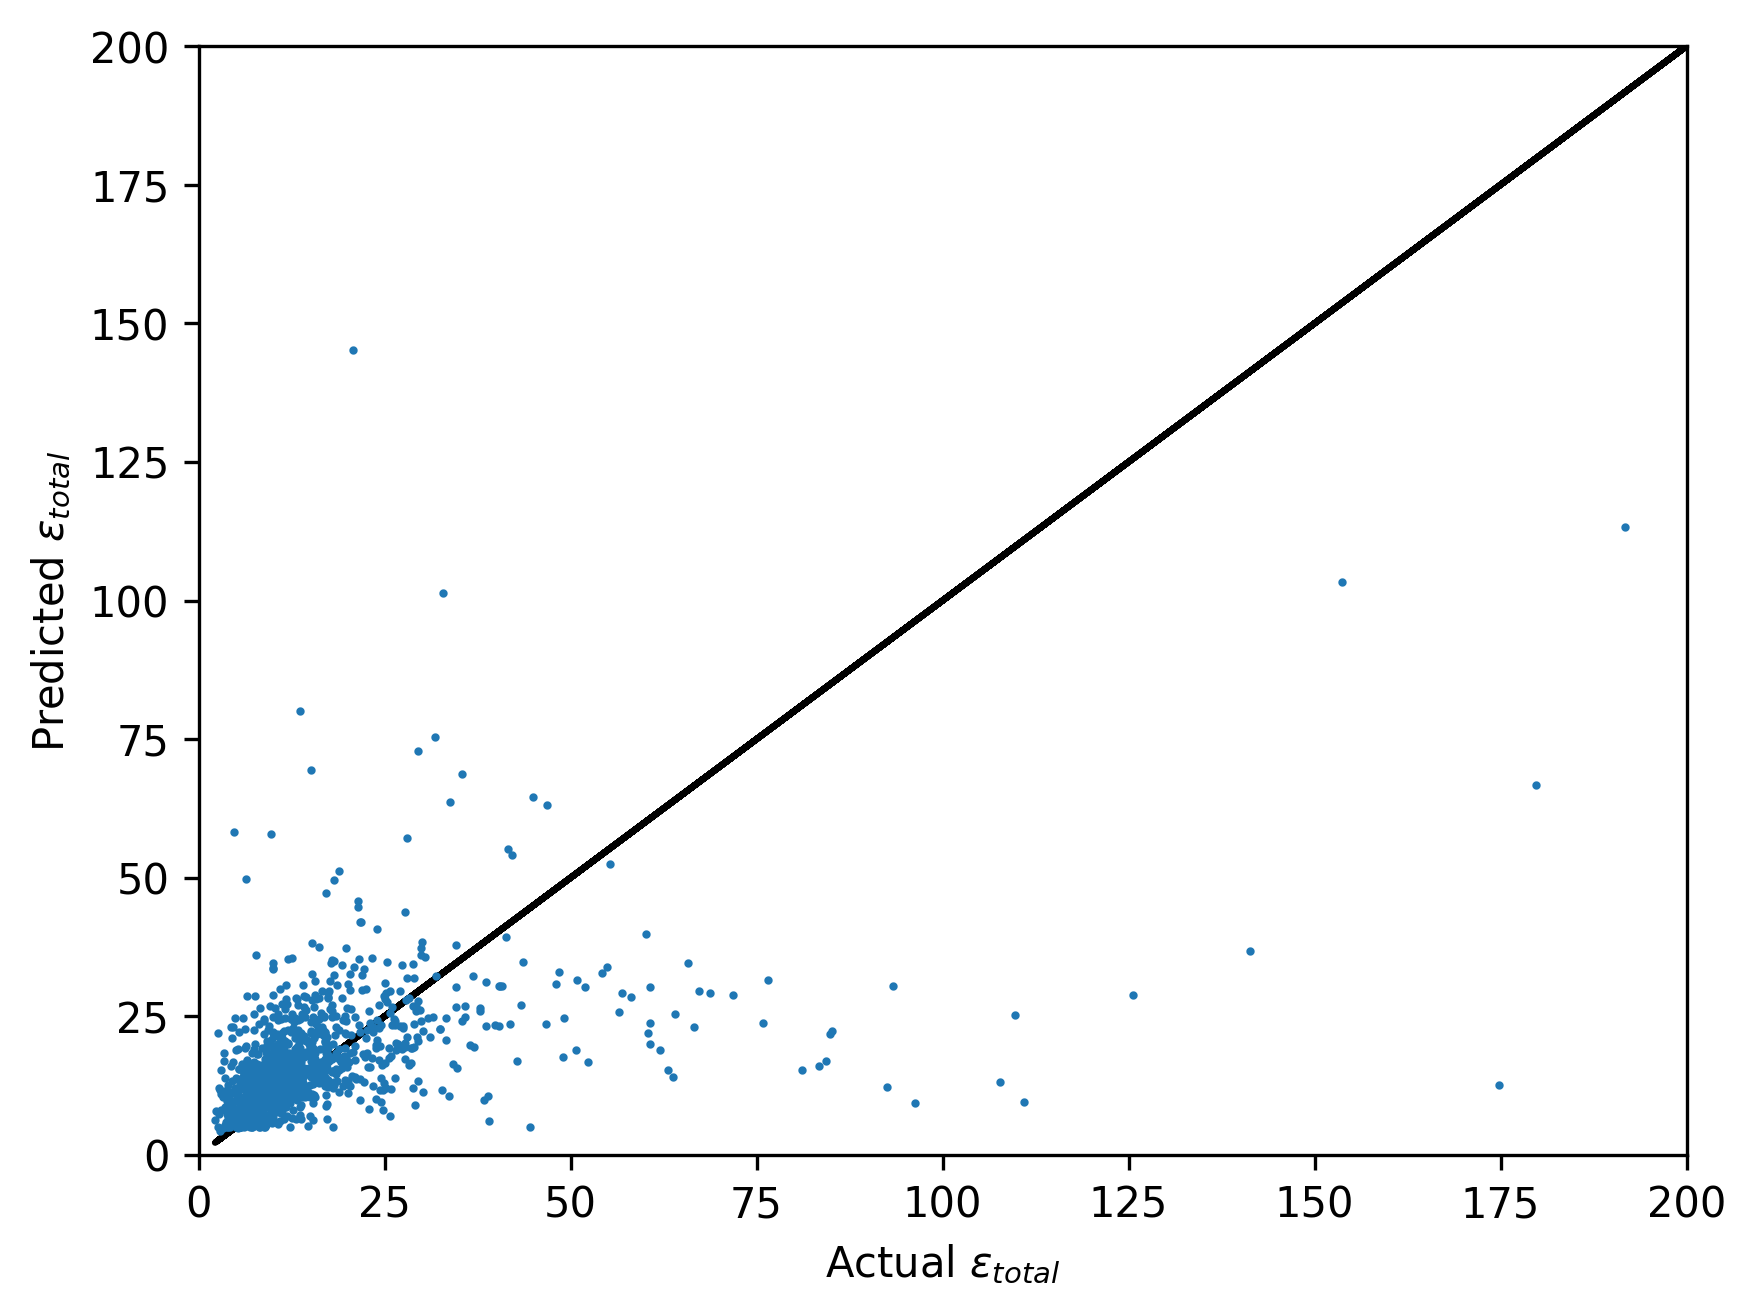

In [36]:
# group4
model_4 = nn_train_test(X_4, y_4, learning_rate=0.0015, num_epochs=1000)